# Imports

In [1]:
! pip install -q pandas ollama black tqdm tabulate matplotlib seaborn

In [2]:
import pandas as pd
import ollama
from tqdm.auto import tqdm
from dataclasses import dataclass
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Read and Examine the Data

In [3]:
df = pd.read_csv("data/DATASET.csv").dropna()
df

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE
...,...,...
52697,Yes the best,POSITIVE
52698,Spotify won my heart in Feb 2024 You won my he...,POSITIVE
52699,I tried to open the app and it wont open I res...,POSITIVE
52700,Good,POSITIVE


See the distribution of `label` on the dataset

<Axes: xlabel='label', ylabel='Count'>

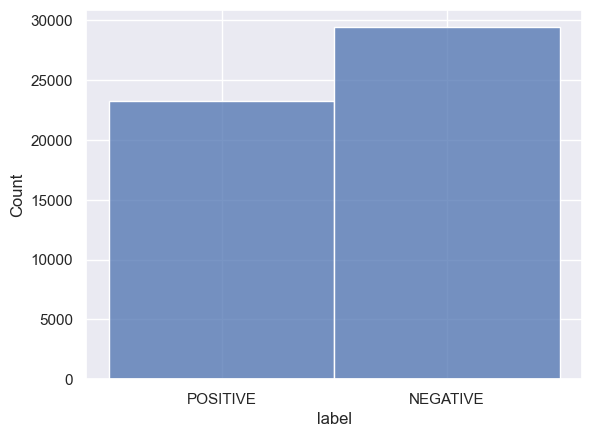

In [4]:
sns.histplot(df["label"])

In [5]:
SAMPLE_SIZE = 500
df = df.sample(SAMPLE_SIZE, random_state=5578416).reset_index(drop=True)
num_samples = len(df)

Let's examine the distribution in the sample

<Axes: xlabel='label', ylabel='Count'>

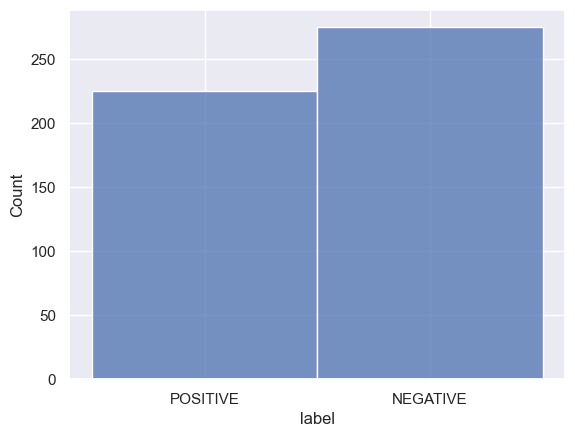

In [6]:
sns.histplot(df["label"])

The distribution is not very biased.

# Prepare Prompts and Helpers

In [7]:
PROMPT_1 = "You are a helpful AI assistant who helps user in syntiment analysis. Given a review in the user message, respond with either `POSITIVE` if the review is positive, or `NEGATIVE` if the review is negative. Respond with ONLY the sentiment and without any elaboration."

PROMPT_2 = "Given the review in the user message, respond with either `POSITIVE` if the review is positive, or `NEGATIVE` if the review is negative. Respond with ONLY the sentiment and without any elaboration."

In [8]:
def run(model: str, system_prompt: str, review: str) -> str:
    response = ollama.chat(
        model=model,
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": review,
            },
        ],
        options={"temperature": 0},
    )
    answer = response["message"]["content"].strip()
    if answer == "POSITIVE":
        return "POSITIVE"
    if answer == "NEGATIVE":
        return "NEGATIVE"
    return "FAILED"

In [9]:
models = ["llama3.2:1b", "llama3.2:3b"]
prompts = {"prompt_1": PROMPT_1, "prompt_2": PROMPT_2}

for model in tqdm(models):
    for prompt_name, prompt in prompts.items():
        df[model + "::" + prompt_name] = ""
        for i in tqdm(range(len(df))):
            df.at[i, model + "::" + prompt_name] = run(model, prompt, df["Review"][i])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
df

,Review,label,llama3.2:1b::prompt_1,llama3.2:1b::prompt_2,llama3.2:3b::prompt_1,llama3.2:3b::prompt_2
0,Since my podcast is on here I am learning a gr...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE
1,"Terrible sound quality, noticably worse than a...",NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
2,The UI malfunctioning in dark mode.,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
3,Actually this app deserves 5 stars but I give ...,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE,POSITIVE
4,BESTTT,POSITIVE,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE
...,...,...,...,...,...,...
495,I really love this app but it has 1 problem. S...,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,POSITIVE
496,The experience could be improved for offline m...,NEGATIVE,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE
497,Other than ads all is okay,POSITIVE,NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE
498,After this latest update I'm having issues wit...,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE


# Examine the Results

In [11]:
@dataclass
class ModelStats:
    model_name: str
    propmt_name: str
    following_instructions_and_correct_count: int
    following_instructions_and_incorrect_count: int
    not_following_instructions_count: int

    @property
    def following_instructions_and_correct(self):
        return self.following_instructions_and_correct_count / num_samples

    @property
    def following_instructions_and_incorrect(self):
        return self.following_instructions_and_incorrect_count / num_samples

    @property
    def not_following_instructions(self):
        return self.not_following_instructions_count / num_samples


model_stats = []
for model in models:
    for prompt_name in prompts.keys():
        col = model + "::" + prompt_name
        correct_count = (df[col] == df["label"]).sum()
        incorrect_count = (df[col] != df["label"]).sum()
        not_following_instructions_count = (df[col] == "FAILED").sum()
        model_stats.append(
            ModelStats(
                model_name=model,
                propmt_name=prompt_name,
                following_instructions_and_correct_count=correct_count,
                following_instructions_and_incorrect_count=incorrect_count,
                not_following_instructions_count=not_following_instructions_count,
            )
        )


print(
    tabulate(
        [
            ["Model", *[s.model_name for s in model_stats]],
            ["Prompt", *[s.propmt_name for s in model_stats]],
            [
                "Following Instruction and Correct",
                *[f"{s.following_instructions_and_correct:2.2%}" for s in model_stats],
            ],
            [
                "Following Instruction and Incorrect",
                *[
                    f"{s.following_instructions_and_incorrect:2.2%}"
                    for s in model_stats
                ],
            ],
            [
                "Not Following Instructions",
                *[f"{s.not_following_instructions:2.2%}" for s in model_stats],
            ],
            [
                "Correct (Count)",
                *[s.following_instructions_and_correct_count for s in model_stats],
            ],
            [
                "Incorrect (Count)",
                *[s.following_instructions_and_incorrect_count for s in model_stats],
            ],
            [
                "Not Following Instructions (Count)",
                *[s.not_following_instructions_count for s in model_stats],
            ],
        ],
        tablefmt="fancy_grid",
    )
)

╒═════════════════════════════════════╤═════════════╤═════════════╤═════════════╤═════════════╕
│ Model                               │ llama3.2:1b │ llama3.2:1b │ llama3.2:3b │ llama3.2:3b │
├─────────────────────────────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ Prompt                              │ prompt_1    │ prompt_2    │ prompt_1    │ prompt_2    │
├─────────────────────────────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ Following Instruction and Correct   │ 77.20%      │ 82.80%      │ 86.20%      │ 86.60%      │
├─────────────────────────────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ Following Instruction and Incorrect │ 22.80%      │ 17.20%      │ 13.80%      │ 13.40%      │
├─────────────────────────────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ Not Following Instructions          │ 0.00%       │ 0.20%       │ 0.40%       │ 0.00%       │
├─────────────────────────────────────┼─

Let's look at disagreements on `prompt_2` since it's the one with better performance.

In [12]:
llama1b_prompt2_disagreements = df[df["llama3.2:1b::prompt_2"] != df["label"]]
llama3b_prompt2_disagreements = df[df["llama3.2:3b::prompt_2"] != df["label"]]

In [13]:
llama1b_prompt2_disagreements[["Review", "label", "llama3.2:1b::prompt_2"]]


,Review,label,llama3.2:1b::prompt_2
3,Actually this app deserves 5 stars but I give ...,NEGATIVE,POSITIVE
4,BESTTT,POSITIVE,NEGATIVE
18,I just love Spotify best for kpop music it is ...,NEGATIVE,POSITIVE
25,I am rating Spotify 5 stars because they stood...,NEGATIVE,POSITIVE
35,This is the only music streaming service I use!,NEGATIVE,POSITIVE
...,...,...,...
464,My premium doesnt work and i tried everything ...,POSITIVE,NEGATIVE
467,I love this app! It's good for good jams and I...,POSITIVE,NEGATIVE
468,The last few times I watched a full ad to get ...,NEGATIVE,POSITIVE
474,Good app,POSITIVE,NEGATIVE


In [14]:
llama3b_prompt2_disagreements[["Review", "label", "llama3.2:3b::prompt_2"]]


,Review,label,llama3.2:3b::prompt_2
3,Actually this app deserves 5 stars but I give ...,NEGATIVE,POSITIVE
25,I am rating Spotify 5 stars because they stood...,NEGATIVE,POSITIVE
32,Was a good app in general but definitely took ...,NEGATIVE,POSITIVE
35,This is the only music streaming service I use!,NEGATIVE,POSITIVE
43,"Pretty cool,but sometimes i ain't able to list...",POSITIVE,NEGATIVE
...,...,...,...
479,"Alot of great songs, but I can never play mine...",POSITIVE,NEGATIVE
485,Keeps all my music but minor ajusents need to ...,NEGATIVE,POSITIVE
495,I really love this app but it has 1 problem. S...,NEGATIVE,POSITIVE
496,The experience could be improved for offline m...,NEGATIVE,POSITIVE


Let's see how much their mistakes correlate

In [15]:
intersection = llama3b_prompt2_disagreements.index.intersection(llama1b_prompt2_disagreements.index)

print(f"Number of mistakes made by both models: {len(intersection)}")
print(f"Number of mistakes made by llama3.2:1b: {len(llama1b_prompt2_disagreements)}")
print(f"Number of mistakes made by llama3.2:3b: {len(llama3b_prompt2_disagreements)}")

llama1b_intersection_ratio = len(intersection) / len(llama1b_prompt2_disagreements)
llama3b_intersection_ratio = len(intersection) / len(llama3b_prompt2_disagreements)

print(f"Mistakes made by both / Mistakes made by llama3.2:1b: {llama1b_intersection_ratio:.2%}")
print(f"Mistakes made by both / Mistakes made by llama3.2:3b: {llama3b_intersection_ratio:.2%}")

Number of mistakes made by both models: 43
Number of mistakes made by llama3.2:1b: 86
Number of mistakes made by llama3.2:3b: 67
Mistakes made by both / Mistakes made by llama3.2:1b: 50.00%
Mistakes made by both / Mistakes made by llama3.2:3b: 64.18%


Let's see how much the review length affects quality

In [16]:
llama1b_prompt2_agreements = df[df["llama3.2:1b::prompt_2"] == df["label"]]
llama3b_prompt2_agreements = df[df["llama3.2:3b::prompt_2"] == df["label"]]


In [17]:
llama1b_correct_len = llama1b_prompt2_agreements["Review"].apply(lambda x: len(x.split()))
llama3b_correct_len = llama3b_prompt2_agreements["Review"].apply(lambda x: len(x.split()))

llama1b_incorrect_len = llama1b_prompt2_disagreements["Review"].apply(lambda x: len(x.split()))
llama3b_incorrect_len = llama3b_prompt2_disagreements["Review"].apply(lambda x: len(x.split()))

max_length = max(llama1b_correct_len.max(), llama3b_correct_len.max(), llama1b_incorrect_len.max(), llama3b_incorrect_len.max()).item()
max_length


104

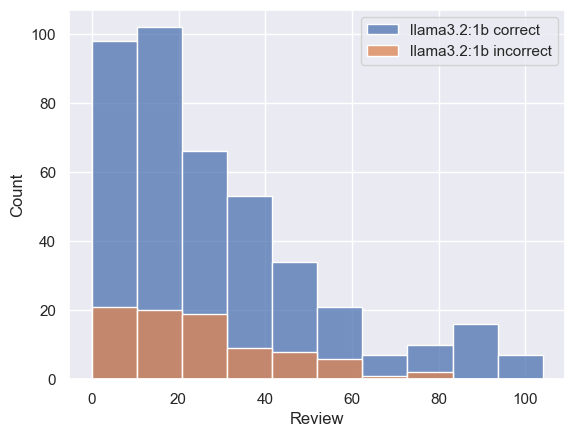

In [18]:
sns.histplot(llama1b_correct_len, binwidth=10, binrange=(0, max_length), label="llama3.2:1b correct")
sns.histplot(llama1b_incorrect_len, binwidth=10, binrange=(0, max_length), label="llama3.2:1b incorrect")
plt.legend()
plt.show()


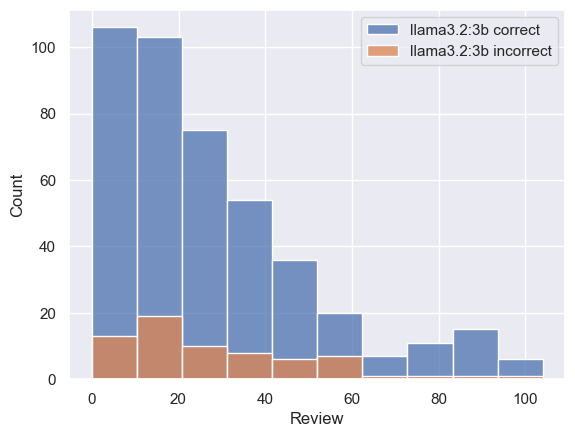

In [19]:
sns.histplot(llama3b_correct_len, binwidth=10, binrange=(0, max_length), label="llama3.2:3b correct")
sns.histplot(llama3b_incorrect_len, binwidth=10, binrange=(0, max_length), label="llama3.2:3b incorrect")
plt.legend()
plt.show()

It seems that as reviews get shorter, we tend to misclassify them, which makes sense.